In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/MyDrive/个人项目/王的机器/python进阶篇代码及资料/案例 1 - 探索股票投资组合/")

Mounted at /content/drive


# <div style="text-align: center"><font color='#dc2624' face='微软雅黑'>Python 进阶之数据分析</font></div>
## <div style="text-align: center"><font color='#dc2624' face='微软雅黑'>案例 1 - 股票投资组合分析</font></div>

## <font color='#dc2624' face='微软雅黑'>目录</font><a name='toc'></a>
### 1. [**<font color='#dc2624' face='微软雅黑'>时间序列</font>**](#1)
1. [<font color='#2b4750' face='微软雅黑'>基本元素</font>](#1.1)
2. [<font color='#2b4750' face='微软雅黑'>基本转换</font>](#1.2)
3. [<font color='#2b4750' face='微软雅黑'>基本函数</font>](#1.3)

### 2. [**<font color='#dc2624' face='微软雅黑'>标准化和重采样</font>**](#2)
1. [<font color='#2b4750' face='微软雅黑'>标准化</font>](#2.1)
2. [<font color='#2b4750' face='微软雅黑'>重采样</font>](#2.2)

### 3. [**<font color='#dc2624' face='微软雅黑'>滚动窗口指标</font>**](#3)
1. [<font color='#2b4750' face='微软雅黑'>滑动之 `rolling`</font>](#3.1)
2. [<font color='#2b4750' face='微软雅黑'>扩展之 `expanding`</font>](#3.2)


### 4. [**<font color='#dc2624' face='微软雅黑'>构建价值加权指数</font>**](#4)
1. [<font color='#2b4750' face='微软雅黑'>选择成分股</font>](#4.1)
2. [<font color='#2b4750' face='微软雅黑'>市值加权指数</font>](#4.2)
3. [<font color='#2b4750' face='微软雅黑'>评估指数表现</font>](#4.3)
4. [<font color='#2b4750' face='微软雅黑'>计算相关性系数</font>](#4.4)

---

# <font color='#dc2624' face='微软雅黑'>目标：</font>

<font face='微软雅黑'> 会在任何一个股票投资组合上创建价值加权指数，并计算每个成分股的对指数收益的贡献度，比对基准 (benchmark) 评估该组合表现，计算相关性系数矩阵来检查组合是否分散。</font>

# <font color='#dc2624' face='微软雅黑'>知识点：</font>

<font face='微软雅黑'> 了解时间序列类型的数据和常用方法，会标准化和重采样操作，计算多种滚动指标。这三个知识点就是 Notebook 的前三节，之后就可以在第四节应用这些知识点来解决实际问题。</font>

# <font color='#dc2624' face='微软雅黑'>数据来源：</font>
<font face='微软雅黑'> 
- 交易所上市公司信息：https://old.nasdaq.com/screening/company-list.aspx
- 股票历史价格数据：https://finance.yahoo.com/
- 失业率数据：https://www.bls.gov/eag/eag.us.htm
- 国民生产总值数据：https://www.statista.com/
</font>

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
np.random.seed(1031)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = [16, 8]
plt.style.use('ggplot')

# <font color='#dc2624' face='微软雅黑'>1. 时间序列</font><a name='1'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)
### <font color='#2b4750' face='微软雅黑'>1.1 基本元素</font><a name='1.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

### <font color='blue' face='微软雅黑'>日期时间</font>
`datetime` 是描述日期和时间的数据类型，我们可用 `datetime` 来创建**日期**和**时间**对象。当时间序列数据存储在 `DataFrame` 的时候，时间日期通常是它的行标签 (`df.index`)。

用 `pd.Timestamp()` 来创建日期，其参数可以 `str` 类型，也可以是 `datetime` 类型。

In [ ]:
d1 = pd.Timestamp('2020-07-28')
d2 = pd.Timestamp(datetime(2020, 7, 28))
print( d1, d2, d1==d2, sep='\n' )

2020-07-28 00:00:00
2020-07-28 00:00:00
True


我们可以查看日期中的一些常用的字段，比如用 `.year` 来看年份，`.weekday` 来看是星期几 (0 代表星期一，...，6 代表星期天)。

In [ ]:
print(d1.year)
print(d1.weekday())

2020
1


### <font color='blue' face='微软雅黑'>期和频率</font>

时间戳 (timestap) 和期 (period) 可以互相转换

- 用 `pd.Period()` 来定义期 (period)
- 用 `.asfreq()` 来更改期频
- 用 `.to_timestamp()` 将期转成时间戳
- 用 `.to_period()` 将时间戳转成期

In [ ]:
period = pd.Period('2020-07')
period

Period('2020-07', 'M')

In [ ]:
dt = period.to_timestamp()
dt

Timestamp('2020-07-01 00:00:00')

In [ ]:
period.asfreq('D')

Period('2020-07-31', 'D')

In [ ]:
period.asfreq('D', how='S')

Period('2020-07-01', 'D')

In [ ]:
dt.to_period('M')

Period('2020-07', 'M')

In [ ]:
period + 2

Period('2020-09', 'M')

### <font color='blue' face='微软雅黑'>时间序列</font>

时间序列顾名思义就是一组时间加上一个序列的变量值，用 `.date_range()` 来创建一组时间，有四个关键参数：

- `start`: 起始时间
- `end`：终止时间
- `periods`：期数
- `freq`：频率 (默认是期数最后一个值)

In [ ]:
index = pd.date_range(start='2020-1-1', periods=12, freq='M')
index

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31'],
              dtype='datetime64[ns]', freq='M')

In [ ]:
index = pd.date_range(start='2020-1-1', periods=12, freq='MS')
index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
index.to_period()

PeriodIndex(['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
             '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12'],
            dtype='period[M]')

`DatetimeIndex` 包含一组 Timestamp 对象，并且还带有频率信息，每个频率有个相应的英文字母对应，如下表所示：

| 期           | 缩写 |
|--------------|:---:|
|小时 (Hour)   | H   |
| 天  (Day)    | D   |
| 周  (Week)   | W   |
| 月  (Month)  | M   |
| 季  (Quarter)| Q   |
| 年  (Year)   | A   |

对于 `Timestamp` 对象，我们也可获取各种有用信息，如下表所示：

|  属性        |
|--------------|
| `.second`, `.minute`, `.hour`|
| `.day`, `.month`, `.quarter`, `.year`|
| `.weekday()` |
| `.dayofweek` |
| `.weekofyear` |
| `.dayofyear` |

In [ ]:
index[0]

Timestamp('2020-01-01 00:00:00', freq='MS')

In [ ]:
print( f'{index[0]} 的属性如下：\n')
print( f'- 天数是 {index[0].day} 天' )
print( f'- 月份是 {index[0].month} 月' )
print( f'- 年份是 {index[0].year} 年' )
print( f'- 是一周中第 {index[0].dayofweek} 天' )
print( f'- 是一年中第 {index[0].dayofyear} 天' )
print( f'- 是一年中第 {index[0].weekofyear} 周' )

2020-01-01 00:00:00 的属性如下：

- 天数是 1 天
- 月份是 1 月
- 年份是 2020 年
- 是一周中第 2 天
- 是一年中第 1 天
- 是一年中第 1 周


创建一个时间序列的数据帧。

In [ ]:
df = pd.DataFrame( data=np.vstack((index.year, index.month, index.day)).T, 
                   index=index, 
                   columns=['Year','Month','Value'] )
df

,Year,Month,Value
2020-01-01,2020,1,1
2020-02-01,2020,2,1
2020-03-01,2020,3,1
2020-04-01,2020,4,1
2020-05-01,2020,5,1
2020-06-01,2020,6,1
2020-07-01,2020,7,1
2020-08-01,2020,8,1
2020-09-01,2020,9,1
2020-10-01,2020,10,1


### <font color='#2b4750' face='微软雅黑'>1.2 基本转换</font><a name='1.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

时间序列转换有三个基本操作：

- 将字符串的日期格式转成 `datetime64` 格式
- 索引或切片时间来获取数据
- 改变 `DateTimeIndex` 的频率，即重采样

### <font color='blue' face='微软雅黑'>转换日期格式</font>

读取特拉斯 5 年的历史信息，用 `.info()` 看出数据帧 `TSLA` 有两列，第一列是 `Date`，其数据类型是 `object` (只要不是数值型变量都是 `object` 类型)。只关注特斯拉每天调整后的收盘价。

In [ ]:
TSLA = pd.read_csv('TSLA.csv')
TSLA = TSLA[['Date','Adj Close']]
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Adj Close  1259 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


为了能使用日期对象中的方法，首要任务是用 `pd.to_datetime()` 将字符串的日期格式转成 `datetime64` 格式。转换之后发现 `Date` 的数据类型变成了 `datetime64[ns]`。

In [ ]:
TSLA.Date = pd.to_datetime(TSLA.Date)
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1259 non-null   datetime64[ns]
 1   Adj Close  1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


In [ ]:
TSLA.head(3).append(TSLA.tail(3))

,Date,Adj Close
0,2015-08-19,255.250000
1,2015-08-20,242.179993
2,2015-08-21,230.770004
1256,2020-08-14,1650.709961
1257,2020-08-17,1835.640015
1258,2020-08-18,1887.089966


对于存储时间序列的数据帧，我们更希望它的**行索引**是 `Date`，用 `set_index()` 即可，并设置 `inplace=True` 使数据帧**原地** (in place) 转变。

In [ ]:
TSLA.set_index('Date',inplace=True)
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-08-19 to 2020-08-18
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1259 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


In [ ]:
TSLA.head(3).append(TSLA.tail(3))

,Adj Close
Date,
2015-08-19,255.250000
2015-08-20,242.179993
2015-08-21,230.770004
2020-08-14,1650.709961
2020-08-17,1835.640015
2020-08-18,1887.089966


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29305 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26031 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_a

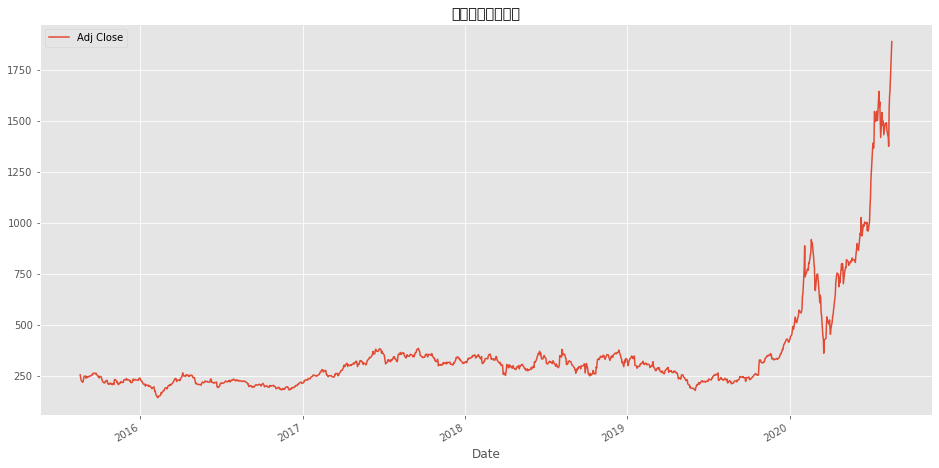

In [ ]:
TSLA.plot(title='特斯拉五年股价图');

注意在用 `Pandas` 从 csv 读取日期时，比如 **08/07/2020** 时把第一个数当成月份，因此理解成了 2020 年 8 月 7 日，而不是 2020 年 7 月 8 日。

- 如果第一个数是月份，那么将 `read_csv()` 中设置 `dayfirst=`**`False`** 即可，或者不写，因为这是默认设置。
- 如果第一个数是天份，那么将 `read_csv()` 中设置 `dayfirst=`**`True`** 即可。

### <font color='blue' face='微软雅黑'>索引切片数据</font>

用**年份**字符串来切片。

In [ ]:
TSLA['2020'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 2020-01-02 to 2020-08-18
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  159 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


In [ ]:
TSLA['2020'].head(3).append(TSLA['2020'].tail(3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


,Adj Close
Date,
2020-01-02,430.260010
2020-01-03,443.010010
2020-01-06,451.540009
2020-08-14,1650.709961
2020-08-17,1835.640015
2020-08-18,1887.089966


用**年份月份**字符串来切片。

In [ ]:
TSLA['2019-12':'2020-2'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2019-12-02 to 2020-02-28
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  61 non-null     float64
dtypes: float64(1)
memory usage: 976.0 bytes


In [ ]:
TSLA['2019-12':'2020-2'].head(3).append(TSLA['2019-12':'2020-2'].tail(3))

,Adj Close
Date,
2019-12-02,334.869995
2019-12-03,336.200012
2019-12-04,333.029999
2020-02-26,778.799988
2020-02-27,679.000000
2020-02-28,667.989990


用**年月日**字符串来索引。

In [ ]:
TSLA.loc['2020-07-14','Adj Close']

1516.800049

### <font color='blue' face='微软雅黑'>改变时间频率</font>

虽然 TSLA 数据帧中股价是按日存储的，但是没有显性**频率** `Freq` 这个信息，频率信息可用 `asfreq()` 来设置。对比

- `TSLA.info()`
- `TSLA.asfreq('D').info()`

后者比前者多了 `Freq: D` 的信息，其中 `'D'` 表示日历日。

In [ ]:
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-08-19 to 2020-08-18
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1259 non-null   float64
dtypes: float64(1)
memory usage: 52.0 KB


用 `asfreq('D')` 后数据从 1259 个变成了 1827 个。从下面的 `1259 non-null` 推断新增了 578 个 NaN 值。

In [ ]:
TSLA.asfreq('D').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2015-08-19 to 2020-08-18
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1259 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


打印最后五行发现有个 `NaN` 值，原因是 2020-08-15 和 2020-08-16 是周末，没有股票交易。

In [ ]:
TSLA.asfreq('D').tail()

,Adj Close
Date,
2020-08-14,1650.709961
2020-08-15,NaN
2020-08-16,NaN
2020-08-17,1835.640015
2020-08-18,1887.089966


如果设置 `asfreq('B')` 再将所有工作日 (Business Date) 的股价打印出来，发现数据减少到 1305 ，但是还是只有 `1259 non-null`，还有 56 天是 `NaN` 值。

In [ ]:
TSLA.asfreq('B').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2015-08-19 to 2020-08-18
Freq: B
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1259 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


In [ ]:
TSLA_B = TSLA.asfreq('B')

In [ ]:
TSLA_B[TSLA_B['Adj Close'].isnull()]

,Adj Close
Date,
2015-09-07,NaN
2015-11-26,NaN
2015-12-25,NaN
2016-01-01,NaN
2016-01-18,NaN
2016-02-15,NaN
2016-03-25,NaN
2016-05-30,NaN
2016-07-04,NaN


发现上面 `NaN` 值对应的日期都是美国公共假期，因此没有股票交易，按理来说**公共假期不属于工作日，非工作日包括周末和公共假期**，但是 `Pandas` 在这一块没有处理好。

### <font color='#2b4750' face='微软雅黑'>1.3 基本函数</font><a name='1.3'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

在时间序列应用的基本函数包括:
- `shift(period=a)`：将变量 $x$ 按日期时间往前 (`a` 为正整数) 或往后 (`a` 为负整数) 移动，其中 `a` 默认为 1
- `diff()`：计算变量 $x$ 在一段时间 $[t_i, t_j]$ 内的**绝对**差异 $x(t_j) - x(t_i)$
- `pct_change()`：计算变量 $x$ 在一段时间 $[t_i, t_j]$ 内的**相对**差异 $\frac{x(t_j)}{x(t_i)}-1$

In [ ]:
TSLA1 = TSLA.copy()
TSLA1.head(3).append(TSLA1.tail(3))

,Adj Close
Date,
2015-08-19,255.250000
2015-08-20,242.179993
2015-08-21,230.770004
2020-08-14,1650.709961
2020-08-17,1835.640015
2020-08-18,1887.089966


In [ ]:
TSLA1['forward'] = TSLA1['Adj Close'].shift()
TSLA1.head(3).append(TSLA1.tail(3))

,Adj Close,forward
Date,,
2015-08-19,255.250000,NaN
2015-08-20,242.179993,255.250000
2015-08-21,230.770004,242.179993
2020-08-14,1650.709961,1621.000000
2020-08-17,1835.640015,1650.709961
2020-08-18,1887.089966,1835.640015


In [ ]:
TSLA1['backward'] = TSLA1['Adj Close'].shift(periods=-1)
TSLA1.head(3).append(TSLA1.tail(3))

,Adj Close,forward,backward
Date,,,
2015-08-19,255.250000,NaN,242.179993
2015-08-20,242.179993,255.250000,230.770004
2015-08-21,230.770004,242.179993,218.869995
2020-08-14,1650.709961,1621.000000,1835.640015
2020-08-17,1835.640015,1650.709961,1887.089966
2020-08-18,1887.089966,1835.640015,NaN


In [ ]:
TSLA2 = TSLA.copy()
TSLA2.head(3).append(TSLA2.tail(3))

,Adj Close
Date,
2015-08-19,255.250000
2015-08-20,242.179993
2015-08-21,230.770004
2020-08-14,1650.709961
2020-08-17,1835.640015
2020-08-18,1887.089966


In [ ]:
TSLA2['diff'] = TSLA2['Adj Close'].diff()
TSLA2.head(3).append(TSLA2.tail(3))

,Adj Close,diff
Date,,
2015-08-19,255.250000,NaN
2015-08-20,242.179993,-13.070007
2015-08-21,230.770004,-11.409989
2020-08-14,1650.709961,29.709961
2020-08-17,1835.640015,184.930054
2020-08-18,1887.089966,51.449951


In [ ]:
TSLA2['diff1'] = TSLA2['Adj Close'].sub(TSLA2['Adj Close'].shift())
TSLA2.head(3).append(TSLA2.tail(3))

,Adj Close,diff,diff1
Date,,,
2015-08-19,255.250000,NaN,NaN
2015-08-20,242.179993,-13.070007,-13.070007
2015-08-21,230.770004,-11.409989,-11.409989
2020-08-14,1650.709961,29.709961,29.709961
2020-08-17,1835.640015,184.930054,184.930054
2020-08-18,1887.089966,51.449951,51.449951


In [ ]:
TSLA2['change'] = TSLA2['diff'].div(TSLA2['Adj Close'].shift()).mul(100)
TSLA2.head(3).append(TSLA2.tail(3))

,Adj Close,diff,diff1,change
Date,,,,
2015-08-19,255.250000,NaN,NaN,NaN
2015-08-20,242.179993,-13.070007,-13.070007,-5.120473
2015-08-21,230.770004,-11.409989,-11.409989,-4.711367
2020-08-14,1650.709961,29.709961,29.709961,1.832817
2020-08-17,1835.640015,184.930054,184.930054,11.203062
2020-08-18,1887.089966,51.449951,51.449951,2.802834


In [ ]:
TSLA2['change1'] = TSLA2['Adj Close'].pct_change().mul(100)
TSLA2.head(3).append(TSLA2.tail(3))

,Adj Close,diff,diff1,change,change1
Date,,,,,
2015-08-19,255.250000,NaN,NaN,NaN,NaN
2015-08-20,242.179993,-13.070007,-13.070007,-5.120473,-5.120473
2015-08-21,230.770004,-11.409989,-11.409989,-4.711367,-4.711367
2020-08-14,1650.709961,29.709961,29.709961,1.832817,1.832817
2020-08-17,1835.640015,184.930054,184.930054,11.203062,11.203062
2020-08-18,1887.089966,51.449951,51.449951,2.802834,2.802834


In [ ]:
TSLA3 = TSLA.copy()
TSLA3.head().append(TSLA3.tail())

,Adj Close
Date,
2015-08-19,255.250000
2015-08-20,242.179993
2015-08-21,230.770004
2015-08-24,218.869995
2015-08-25,220.029999
2020-08-12,1554.760010
2020-08-13,1621.000000
2020-08-14,1650.709961
2020-08-17,1835.640015


In [ ]:
TSLA3['ret_1d'] = TSLA3['Adj Close'].pct_change().mul(100)
TSLA3['ret_2d'] = TSLA3['Adj Close'].pct_change(periods=2).mul(100)
TSLA3['ret_3d'] = TSLA3['Adj Close'].pct_change(periods=3).mul(100)
TSLA3.head().append(TSLA3.tail())

,Adj Close,ret_1d,ret_2d,ret_3d
Date,,,,
2015-08-19,255.250000,NaN,NaN,NaN
2015-08-20,242.179993,-5.120473,NaN,NaN
2015-08-21,230.770004,-4.711367,-9.590596,NaN
2015-08-24,218.869995,-5.156653,-9.625072,-14.252695
2015-08-25,220.029999,0.529997,-4.653987,-9.146087
2020-08-12,1554.760010,13.123640,9.600518,7.024805
2020-08-13,1621.000000,4.260464,17.943232,14.270009
2020-08-14,1650.709961,1.832817,6.171367,20.104915
2020-08-17,1835.640015,11.203062,13.241210,18.065811


# <font color='#dc2624' face='微软雅黑'>2. 标准化和重采样</font><a name='2'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)

一般来讲，不同股票价格的量纲不同，不同股票时间序列的频率也不同，在比较时通常会用

- **标准化** (standardization) 调成同量纲 (same scale)
- **重采样** (resample) 调成同频率 (same frequency)

### <font color='#2b4750' face='微软雅黑'>2.1 标准化</font><a name='2.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

不同的股票价格的量纲不同，蔚来汽车股价在 3-15 之间，京东股价在 40-70 之间，苹果在 350-460 之间，亚马逊在 2500-3300 之间，因此将所有价格标准化到 100 便于比较它们的表现。

读取苹果 (AAPL) 和亚马逊 (AMZN) 的从 2015-08-19 到 2020-08-18 五年的历史数据。

In [ ]:
prices = pd.read_csv('AAPL AMZN.csv', parse_dates=['Date'], index_col='Date')
prices.head(3).append(prices.tail(3))

,AAPL,AMZN
Date,,
2015-08-19,106.282379,532.919983
2015-08-20,104.101456,515.780029
2015-08-21,97.734299,494.470001
2020-08-14,459.630005,3148.020020
2020-08-17,458.429993,3182.409912
2020-08-18,462.250000,3312.489990


打印出时间序列的每个股票的第一个价格。

In [ ]:
prices.iloc[0]

AAPL    106.282379
AMZN    532.919983
Name: 2015-08-19 00:00:00, dtype: float64

将每个股票在时间维度上的所有价格除以对应的第一个价格并都乘上 100，这样就使得所有股票的第一个价格都标准化到 100 了。

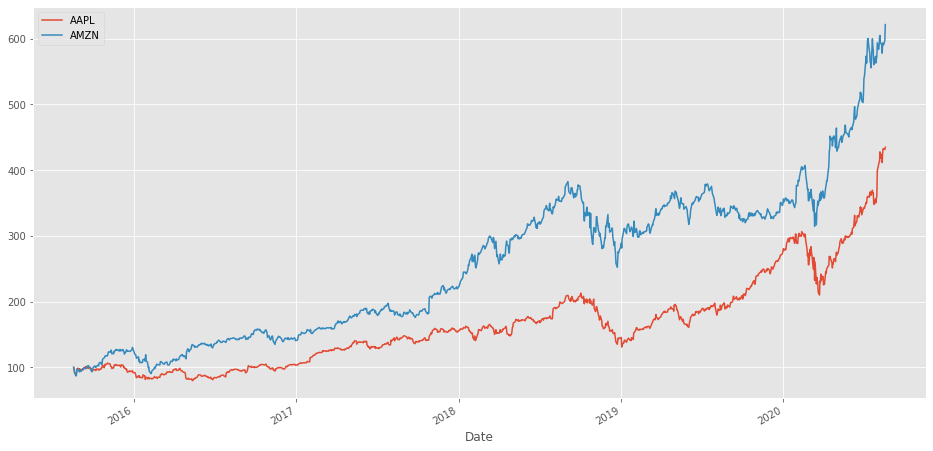

In [ ]:
normalized = prices.div(prices.iloc[0]).mul(100)
normalized.plot();

再读取美股的基准 (benchmark) S&P500 指数，并和之前的苹果和亚马逊的 `DataFrame` 合并。

In [ ]:
sp500 = pd.read_csv('S&P 500.csv', parse_dates=['Date'], index_col='Date')
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-08-19 to 2020-08-18
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  1259 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


In [ ]:
all_prices = pd.concat([prices, sp500], axis=1).dropna()
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-08-19 to 2020-08-18
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AAPL     1259 non-null   float64
 1   AMZN     1259 non-null   float64
 2   S&P 500  1259 non-null   float64
dtypes: float64(3)
memory usage: 39.3 KB


将两只股票和一个指数都做标准化，画图不仅能看出两只股票的相互表现，也能将它们和指数表现相比较。

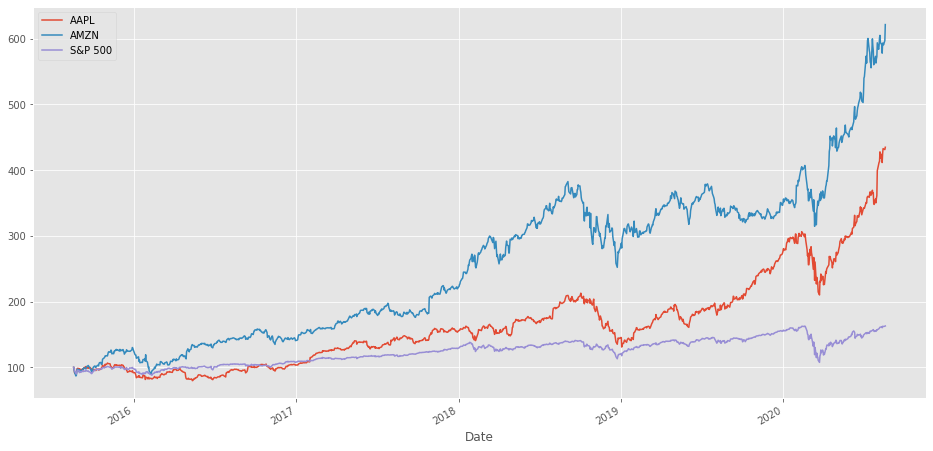

In [ ]:
normalized = all_prices.div(all_prices.iloc[0]).mul(100)
normalized.plot();

此外还可以将计算股票相对指数的表现，即将**标准化**过的股票价格减去**标准化**过的指数水平。

In [ ]:
diff = normalized[prices.columns].sub(normalized['S&P 500'], axis=0)
diff.head()

,AAPL,AMZN
Date,,
2015-08-19,0.000000,0.000000
2015-08-20,0.058009,-1.106217
2015-08-21,-2.814893,-1.987056
2015-08-24,-1.375019,-4.087512
2015-08-25,0.395072,-2.293577


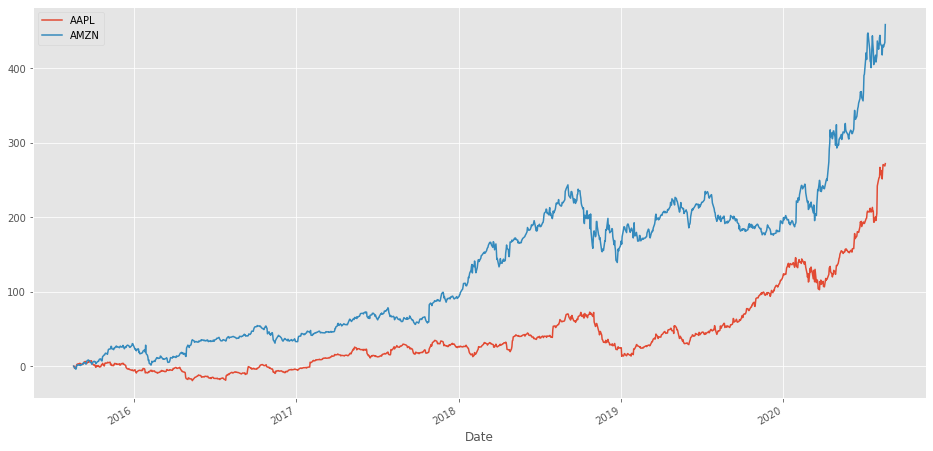

In [ ]:
diff.plot();

### <font color='#2b4750' face='微软雅黑'>2.2 重采样</font><a name='2.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

多个时间序列的频率可能不同，为了比较它们，通常需要改变某些序列的频率，这个过程叫做**重采样 (resampling)**，有两种方法：

- **上采样 (upsampling)**：将低频数据变成高频数据，**填充 (fill)** 或者**内插 (interpolate)** 中间缺失值。
- **下采样 (downsampling)**：将高频数据变成低频数据，将多个数据**整合 (aggregate)** 为一个。

上采样和下采样的比较图如下：

<img src="upsample vs downsample.png" style="width:600px;height:300px;">
<br>

在 `Pandas` 里主要通过 `.asfreq()`, `.reindex()` 和 `.resample()` 方法来重采样。

### <font color='blue' face='微软雅黑'>上采样</font>

### <font color='#blue' face='微软雅黑'>填充</font>

In [ ]:
dates = pd.date_range(start='2020', periods=4, freq='Q')
quarterly = pd.Series(data=np.arange(1,5), index=dates)
quarterly

2020-03-31    1
2020-06-30    2
2020-09-30    3
2020-12-31    4
Freq: Q-DEC, dtype: int64

用 `.asfreq()` 来做上采样。

In [ ]:
monthly = quarterly.asfreq('M')
monthly

2020-03-31    1.0
2020-04-30    NaN
2020-05-31    NaN
2020-06-30    2.0
2020-07-31    NaN
2020-08-31    NaN
2020-09-30    3.0
2020-10-31    NaN
2020-11-30    NaN
2020-12-31    4.0
Freq: M, dtype: float64

In [ ]:
monthly = monthly.to_frame('baseline')
monthly

,baseline
2020-03-31,1.0
2020-04-30,NaN
2020-05-31,NaN
2020-06-30,2.0
2020-07-31,NaN
2020-08-31,NaN
2020-09-30,3.0
2020-10-31,NaN
2020-11-30,NaN
2020-12-31,4.0


在 `asfreq()` 函数中设置 `method` 参数来填充 `nan` 值：

- 设置 `method=ffill`: 向前填充
- 设置 `method=bfill`: 向后填充
- 设置 `fill_value=a`: 填充具体值 a

In [ ]:
monthly['ffill'] = quarterly.asfreq('M', method='ffill')
monthly['bfill'] = quarterly.asfreq('M', method='bfill')
monthly['value'] = quarterly.asfreq('M', fill_value=-1)
monthly

,baseline,ffill,bfill,value
2020-03-31,1.0,1,1,1
2020-04-30,NaN,1,2,-1
2020-05-31,NaN,1,2,-1
2020-06-30,2.0,2,2,2
2020-07-31,NaN,2,3,-1
2020-08-31,NaN,2,3,-1
2020-09-30,3.0,3,3,3
2020-10-31,NaN,3,4,-1
2020-11-30,NaN,3,4,-1
2020-12-31,4.0,4,4,4


除此之外，还可以用 `.reindex()` 来做上采样。

In [ ]:
dates = pd.date_range(start='2020', periods=12, freq='M')
monthly = quarterly.reindex(dates)
monthly

2020-01-31    NaN
2020-02-29    NaN
2020-03-31    1.0
2020-04-30    NaN
2020-05-31    NaN
2020-06-30    2.0
2020-07-31    NaN
2020-08-31    NaN
2020-09-30    3.0
2020-10-31    NaN
2020-11-30    NaN
2020-12-31    4.0
Freq: M, dtype: float64

在 `reindex()` 函数中设置 `method` 参数来填充 `nan` 值，和上面 `asfreq()` 的做法一样。

In [ ]:
monthly = monthly.to_frame('baseline')
monthly['ffill'] = quarterly.reindex(dates, method='ffill')
monthly['bfill'] = quarterly.reindex(dates, method='bfill')
monthly['value'] = quarterly.reindex(dates, fill_value=-1)
monthly

,baseline,ffill,bfill,value
2020-01-31,NaN,NaN,1,-1
2020-02-29,NaN,NaN,1,-1
2020-03-31,1.0,1.0,1,1
2020-04-30,NaN,1.0,2,-1
2020-05-31,NaN,1.0,2,-1
2020-06-30,2.0,2.0,2,2
2020-07-31,NaN,2.0,3,-1
2020-08-31,NaN,2.0,3,-1
2020-09-30,3.0,3.0,3,3
2020-10-31,NaN,3.0,4,-1


### <font color='#blue' face='微软雅黑'>插值</font>
读取**按月**公布失业率 (unemployment rate) 数据，公布日都是每月的第一天。

In [ ]:
UR = pd.read_csv('Unemployment Rate.csv', parse_dates=['Date'], index_col='Date')
UR.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2011-01-01 to 2020-06-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unemployment Rate  114 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


In [ ]:
UR.head(3).append(UR.tail(3))

,Unemployment Rate
Date,
2011-01-01,9.1
2011-02-01,9.0
2011-03-01,9.0
2020-04-01,14.7
2020-05-01,13.3
2020-06-01,11.1


可选择不同的偏移 (offset) 来重采样。以 2017 年 4 月为例

| 频率      | 缩写        |采样日期 |
|-----------|:------------:|:---:|
| 最后日历日 | M        |2017-04-30 |
| 第一日历日 | MS        |2017-04-01 |
| 最后工作日 | BM        |2017-04-28 |
| 第一工作日 | BMS        |2017-04-03 |

按照每年为频率做重采样，计算每年所有月份的均值，然后记录在每年第一个日历日上，在 `resample()` 函数中设置 `rule='YS'` 即可，如果是记录在每年最后一个工作上，那么设置 `rule='BY'` 即可。

In [ ]:
UR.resample('YS').mean()

,Unemployment Rate
Date,
2011-01-01,8.933333
2012-01-01,8.075000
2013-01-01,7.358333
2014-01-01,6.158333
2015-01-01,5.275000
2016-01-01,4.875000
2017-01-01,4.341667
2018-01-01,3.891667
2019-01-01,3.666667


读取**按季**公布国民生产总值 (GDP) 数据，公布日都是每月的第一天。这里的 GDP 实际上指的是 GDP 增长率。

In [ ]:
GDP = pd.read_csv('GDP%.csv', parse_dates=['Date'], index_col='Date')
GDP.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2011-01-01 to 2020-04-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GDP Growth  38 non-null     float64
dtypes: float64(1)
memory usage: 608.0 bytes


In [ ]:
GDP.head(3).append(GDP.tail(3))

,GDP Growth
Date,
2011-01-01,-1.0
2011-04-01,2.9
2011-07-01,-0.1
2019-10-01,2.1
2020-01-01,-5.0
2020-04-01,-32.9


由于 GDP 是按季度公布，为了和 UR 相比较，我们可以上采样到按月频率，中间的缺失值可以用 `ffill()` 来向前填充，或者用 `interpolate()` 来内插。

In [ ]:
GDP1 = GDP.resample('MS').ffill().add_suffix('_ffill')
GDP1.head(3).append(GDP1.tail(3))

,GDP Growth_ffill
Date,
2011-01-01,-1.0
2011-02-01,-1.0
2011-03-01,-1.0
2020-02-01,-5.0
2020-03-01,-5.0
2020-04-01,-32.9


In [ ]:
GDP2 = GDP.resample('MS').interpolate().add_suffix('_interp')
GDP2.head(3).append(GDP2.tail(3))

,GDP Growth_interp
Date,
2011-01-01,-1.0
2011-02-01,0.3
2011-03-01,1.6
2020-02-01,-14.3
2020-03-01,-23.6
2020-04-01,-32.9


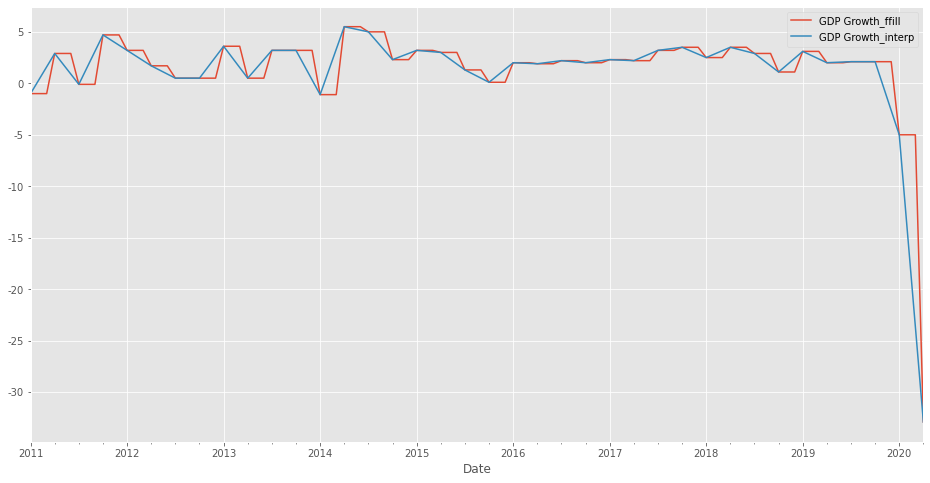

In [ ]:
pd.concat([GDP1, GDP2], axis=1).plot();

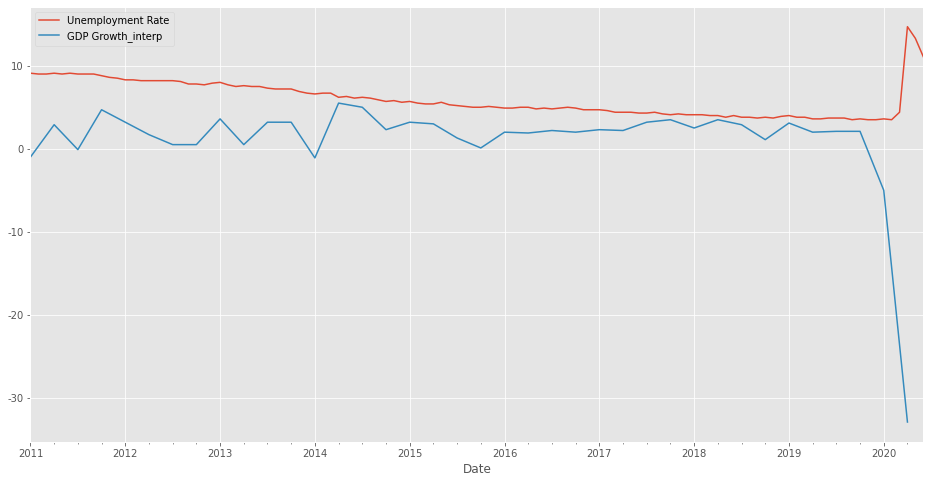

In [ ]:
pd.concat([UR, GDP2], axis=1).plot();

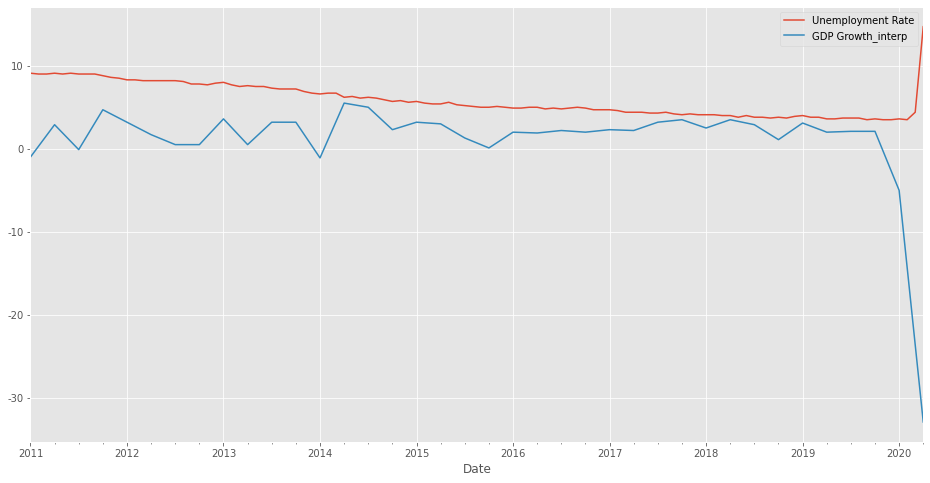

In [ ]:
pd.concat([UR, GDP2], axis=1).dropna().plot();

### <font color='blue' face='微软雅黑'>下采样</font>

下采样是将高频率数据转换成低频率数据，比如从毫秒到分钟，比如从天到周或月等等，在转换成过程中用到**整合函数**包括均值、中位数、最大值等等。

In [ ]:
AAPL = pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col='Date')
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-08-19 to 2020-08-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


In [ ]:
AAPL['Adj Close'].resample('W').agg(['mean', 'std']).tail()

,mean,std
Date,,
2020-07-26,381.783643,10.724913
2020-08-02,387.742895,20.845335
2020-08-09,442.306787,7.779992
2020-08-16,452.024005,9.141875
2020-08-23,460.339996,2.701153


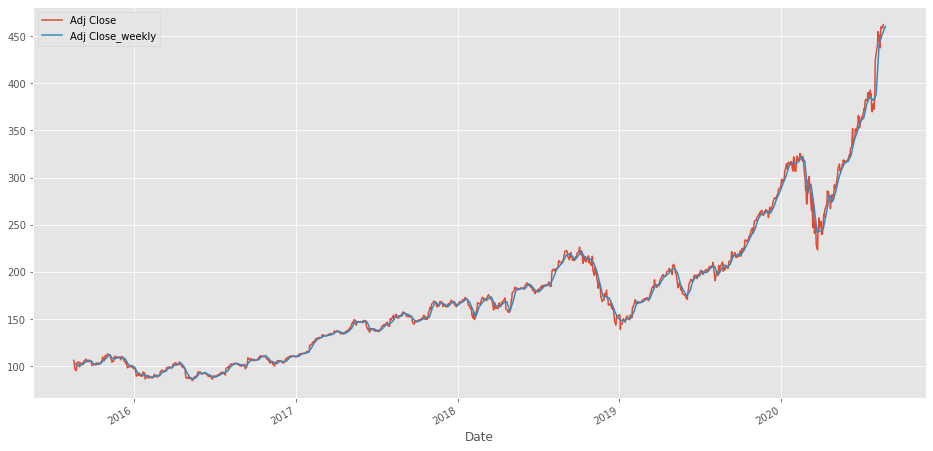

In [ ]:
ax = AAPL[['Adj Close']].plot()
weekly = AAPL[['Adj Close']].resample('W').mean()
weekly.add_suffix('_weekly').plot(ax=ax);

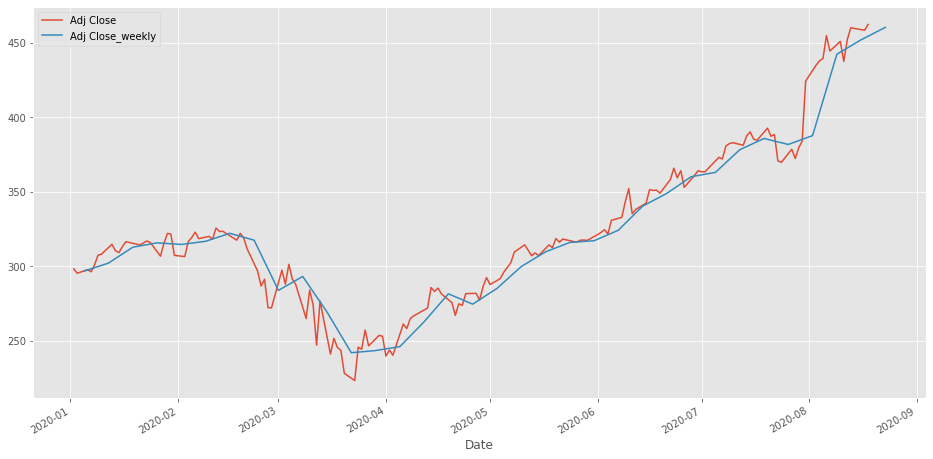

In [ ]:
ax = AAPL.loc['2020',['Adj Close']].plot()
weekly = AAPL.loc['2020',['Adj Close']].resample('W').mean()
weekly.add_suffix('_weekly').plot(ax=ax);

# <font color='#dc2624' face='微软雅黑'>3. 滚动窗口指标</font><a name='3'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)

1. 窗口期 (window) 定义时间序列的子期 (sub-period)。
2. 在窗口期中计算每一个子期的指标
3. 创建一个关于指标的新的时间序列
4. 两种窗口期：
    - Rolling: 相同大小，滑动
    - Expanding: 越来越大，扩张 

下图展示了 rolling 和 expanding 的区别。

<img src="rolling vs expanding.png" style="width:600px;height:300px;">

### <font color='#2b4750' face='微软雅黑'>3.1 滑动之 `rolling`</font><a name='3.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#3)

In [ ]:
sp500 = pd.read_csv('S&P 500.csv', parse_dates=['Date'], index_col='Date')
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-08-19 to 2020-08-18
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   S&P 500  1259 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


In [ ]:
sp500

,S&P 500
Date,
2015-08-19,2079.610107
2015-08-20,2035.729980
2015-08-21,1970.890015
2015-08-24,1893.209961
2015-08-25,1867.609985
...,...
2020-08-12,3380.350098
2020-08-13,3373.429932
2020-08-14,3372.850098


计算滚动平均，设置 `window=30` 将窗口设为 30 个工作日。由于以 30 天为单位滚动，那么**滚动平均**前 29 个值都是 `nan`。我们可以设置`min_periods` 来控制计算平均的最小窗口

- 10 代表最小窗口天数为 10，那么前 9 个值都是 `nan` 
- 9 代表最小窗口天数为 9，那么前 8 个值都是 `nan` 

                    ...

- 2 代表最小窗口天数为 2，那么前 1 个值都是 `nan` 
- 1 代表最小窗口天数为 1，没有 `nan` 值 

In [ ]:
data = pd.DataFrame()
for p in np.arange(1,11):
    data['Period '+str(p)] = sp500.rolling(window=30,min_periods=p).mean().values[:,0]
data.head(10)

,Period 1,Period 2,Period 3,Period 4,Period 5,Period 6,Period 7,Period 8,Period 9,Period 10
0,2079.610107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2057.670044,2057.670044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2028.743367,2028.743367,2028.743367,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1994.860016,1994.860016,1994.860016,1994.860016,NaN,NaN,NaN,NaN,NaN,NaN
4,1969.410010,1969.410010,1969.410010,1969.410010,1969.410010,NaN,NaN,NaN,NaN,NaN
5,1964.593343,1964.593343,1964.593343,1964.593343,1964.593343,1964.593343,NaN,NaN,NaN,NaN
6,1967.888585,1967.888585,1967.888585,1967.888585,1967.888585,1967.888585,1967.888585,NaN,NaN,NaN
7,1970.511261,1970.511261,1970.511261,1970.511261,1970.511261,1970.511261,1970.511261,1970.511261,NaN,NaN
8,1970.696682,1970.696682,1970.696682,1970.696682,1970.696682,1970.696682,1970.696682,1970.696682,1970.696682,NaN
9,1965.012012,1965.012012,1965.012012,1965.012012,1965.012012,1965.012012,1965.012012,1965.012012,1965.012012,1965.012012


除了用整数代表窗口，还可以用字符串代表偏移 (offset)，这是注意 `min_periods` 默认为 1。

In [ ]:
sp500.rolling(window='30D').mean()

,S&P 500
Date,
2015-08-19,2079.610107
2015-08-20,2057.670044
2015-08-21,2028.743367
2015-08-24,1994.860016
2015-08-25,1969.410010
...,...
2020-08-12,3274.468184
2020-08-13,3282.464089
2020-08-14,3289.113636


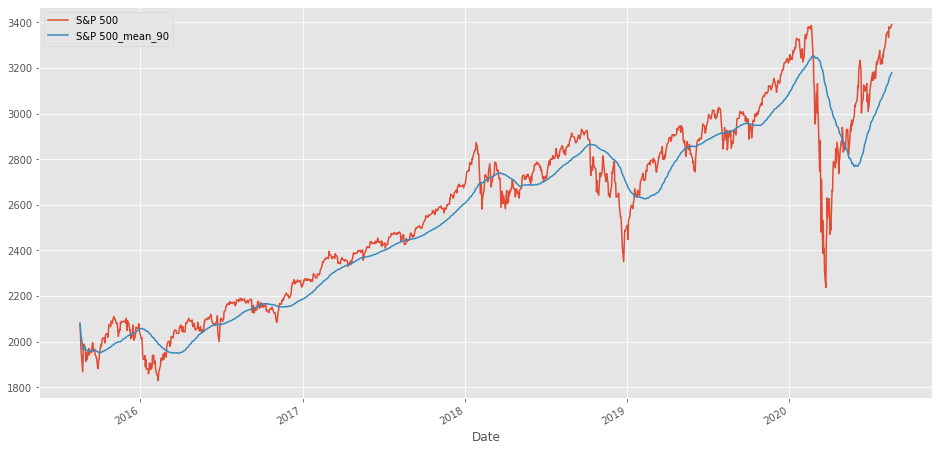

In [ ]:
r90 = sp500.rolling(window='90D').mean()
sp500.join(r90.add_suffix('_mean_90')).plot();

**指标一**：计算并可视化出 90 天滚动平均和标准差。

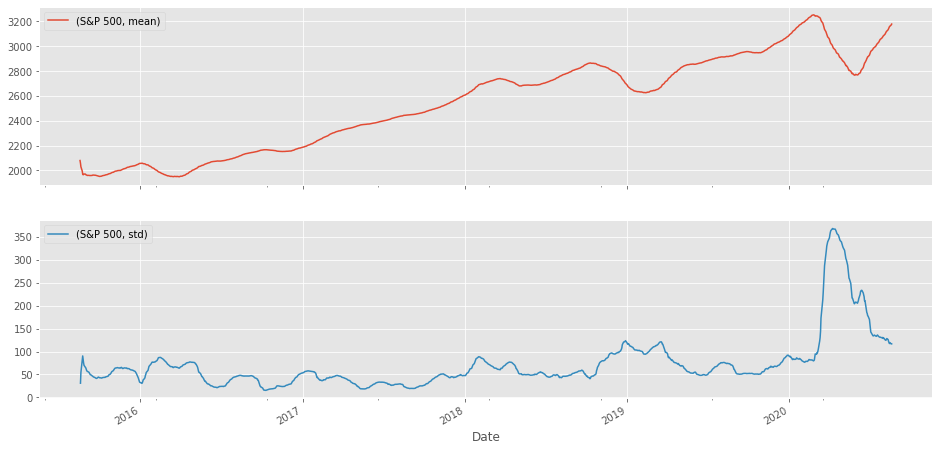

In [ ]:
sp500.rolling('90D').agg(['mean', 'std']).plot(subplots=True);

**指标二**：计算并可视化出 252 天滚动 10 分位数、中位数和 90 分位数。

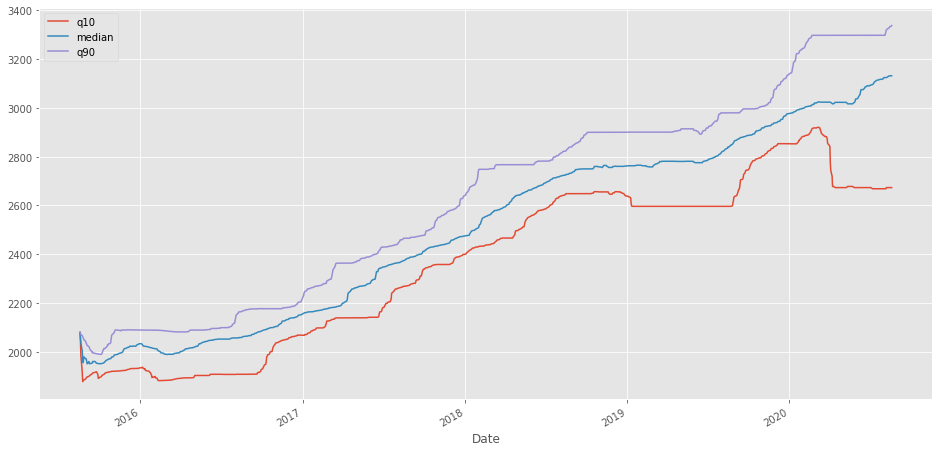

In [ ]:
rolling = sp500['S&P 500'].rolling('252D')
q10 = rolling.quantile(0.1).to_frame('q10')
median = rolling.median().to_frame('median')
q90 = rolling.quantile(0.9).to_frame('q90')
pd.concat([q10, median, q90], axis=1).plot();

### <font color='#2b4750' face='微软雅黑'>3.2 扩展之 `expanding`</font><a name='3.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#3)

举一个简单的例子。

In [ ]:
df = pd.DataFrame({'data': range(5)})
df['expanding sum'] = df.data.expanding().sum()
df['cumulative sum'] = df.data.cumsum()
df

,data,expanding sum,cumulative sum
0,0,0.0,0
1,1,1.0,1
2,2,3.0,3
3,3,6.0,6
4,4,10.0,10


用 `.expanding()` 函数使得每次计算统计量是都包含时间序列所有的历史数据。

首先计算 S&P 500 的累计收益并可视化。

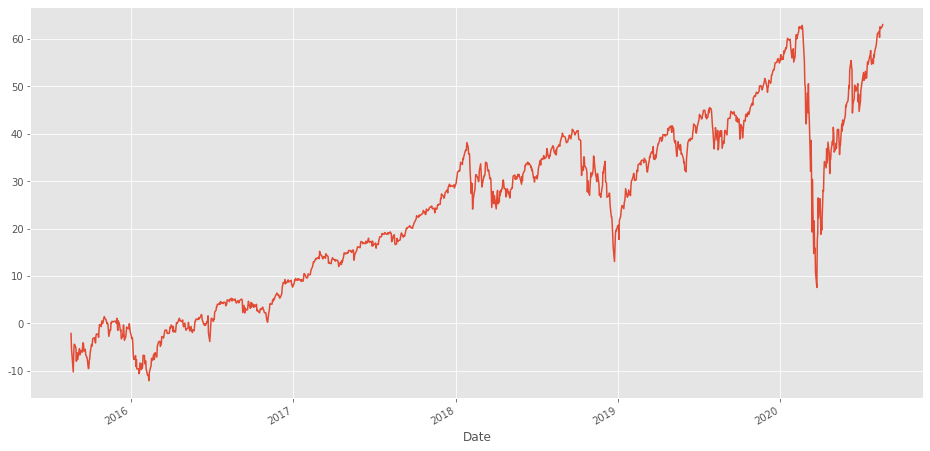

In [ ]:
prd_ret = sp500['S&P 500'].pct_change()
ret_plus_one = prd_ret.add(1)
cum_ret = ret_plus_one.cumprod().sub(1)
sp500['Cumulative Return'] = cum_ret
cum_ret.mul(100).plot();

再用 `.expanding()` 加上 `.min()` 和 `.max()` 来计算 S&P 500 的历史最低和最高。 

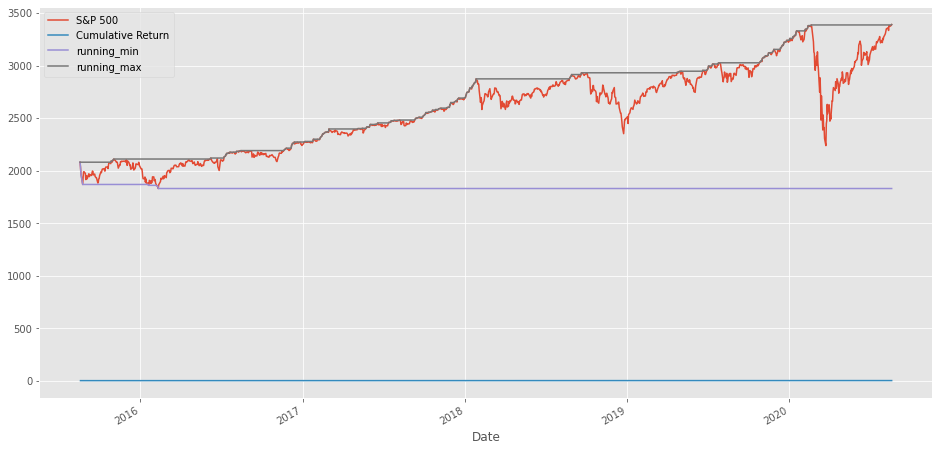

In [ ]:
sp500['running_min'] = sp500['S&P 500'].expanding().min()
sp500['running_max'] = sp500['S&P 500'].expanding().max()
sp500.plot();

此外，我们还可以用 `expanding()` 函数统计历史上 S&P 500 有多少天是上涨的。

In [ ]:
record = pd.DataFrame()
record['涨跌'] = prd_ret.apply(lambda x: 1 if x>0 else 0)
record['涨的天数'] = record['涨跌'].expanding().sum()
record

,涨跌,涨的天数
Date,,
2015-08-19,0,0.0
2015-08-20,0,0.0
2015-08-21,0,0.0
2015-08-24,0,0.0
2015-08-25,0,0.0
...,...,...
2020-08-12,1,690.0
2020-08-13,0,690.0
2020-08-14,0,690.0


最后我们来计算滚动 1 年的收益和累计收益。

In [ ]:
def multi_period_return(r):
    return np.prod(r + 1) - 1

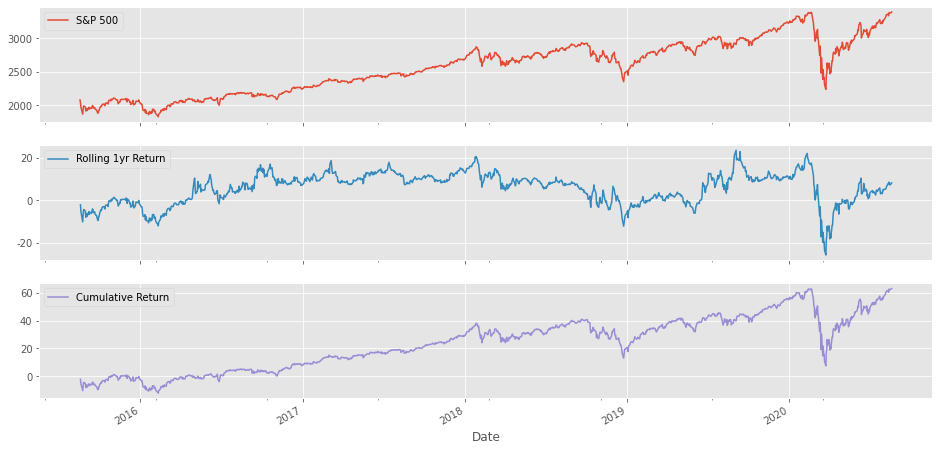

In [ ]:
sp500['Rolling 1yr Return'] = prd_ret.rolling('252D').apply(multi_period_return).mul(100)
sp500['Cumulative Return'] = prd_ret.expanding().apply(multi_period_return).mul(100)
sp500[['S&P 500','Rolling 1yr Return','Cumulative Return']].plot(subplots=True);

# <font color='#dc2624' face='微软雅黑'>4. 构建价值加权指数</font><a name='4'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)

本节中我们使用一个非常简单的策略，从纳斯达克证券交易场所中交易的 3671 只股票按照 12 个行业选取市值最大的公司对应的股票，以市值当权重构建一个组合。本节涉及的内容如下：

1. 从交易所数据按行业划分找到市值最大的成分股
2. 从这些股票的历史数据和最新股票总数来构建指数
3. 选取基准来评估组合表现
4. 计算组合相关性系数

从 https://old.nasdaq.com/screening/company-list.aspx 中下载数据，里面有纳斯达克场外证券交易市场 (NASDAQ)、纽交所 (NYSE) 和美国证券交易所 (AMEX) 的日更的成分股票数据。我将三个交易所的数据整体到一份 listing.xlsx。

### <font color='#2b4750' face='微软雅黑'>4.1 选择成分股</font><a name='4.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#4)

从 excel 的 nasdaq 工作页中读取纳斯达克场外证券交易市场的数据，并定义 NA 值为 `n/a`。

In [5]:
listing = pd.read_excel('listings.xlsx', sheet_name='nasdaq', na_values='n/a')
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3671 entries, 0 to 3670
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Stock Symbol           3671 non-null   object 
 1   Company Name           3671 non-null   object 
 2   Last Sale              3637 non-null   float64
 3   Market Capitalization  3671 non-null   float64
 4   IPO Year               1746 non-null   float64
 5   Sector                 3121 non-null   object 
 6   Industry               3121 non-null   object 
dtypes: float64(3), object(4)
memory usage: 200.9+ KB


/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [6]:
listing

,Stock Symbol,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry
0,TXG,"10x Genomics, Inc.",105.4200,1.057983e+10,2019.0,Capital Goods,Biotechnology: Laboratory Analytical Instruments
1,YI,"111, Inc.",6.7700,1.727144e+08,2018.0,Health Care,Medical/Nursing Services
2,PIH,"1347 Property Insurance Holdings, Inc.",4.4500,2.700307e+07,2014.0,Finance,Property-Casualty Insurers
3,PIHPP,"1347 Property Insurance Holdings, Inc.",25.3382,0.000000e+00,NaN,Finance,Property-Casualty Insurers
4,TURN,180 Degree Capital Corp.,1.9900,6.193191e+07,NaN,Finance,Finance/Investors Services
...,...,...,...,...,...,...,...
3666,ZS,"Zscaler, Inc.",127.9700,1.670242e+10,2018.0,Technology,EDP Services
3667,ZUMZ,Zumiez Inc.,24.0500,6.116111e+08,2005.0,Consumer Services,Clothing/Shoe/Accessory Stores
3668,ZYNE,"Zynerba Pharmaceuticals, Inc.",3.8700,1.132175e+08,2015.0,Health Care,Major Pharmaceuticals
3669,ZYXI,"Zynex, Inc.",16.1300,5.598006e+08,NaN,Health Care,Biotechnology: Electromedical & Electrotherape...


将 `Stock Symbol` 作为行标签，删除 `Sector` 列下 `n/a` 值，这两个操作都是原地 (in-place) 进行的，因此设置 `inplace=`**`True`**。 再将市值单位转化成**每百万美元**，因此除以 $10^6$。

In [7]:
listing.set_index('Stock Symbol', inplace=True)
listing.dropna(subset=['Sector'], inplace=True)
listing['Market Capitalization'] /= 1e6
listing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3121 entries, TXG to ZNGA
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company Name           3121 non-null   object 
 1   Last Sale              3114 non-null   float64
 2   Market Capitalization  3121 non-null   float64
 3   IPO Year               1706 non-null   float64
 4   Sector                 3121 non-null   object 
 5   Industry               3121 non-null   object 
dtypes: float64(3), object(3)
memory usage: 170.7+ KB


In [8]:
listing

,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry
Stock Symbol,,,,,,
TXG,"10x Genomics, Inc.",105.4200,10579.834184,2019.0,Capital Goods,Biotechnology: Laboratory Analytical Instruments
YI,"111, Inc.",6.7700,172.714439,2018.0,Health Care,Medical/Nursing Services
PIH,"1347 Property Insurance Holdings, Inc.",4.4500,27.003072,2014.0,Finance,Property-Casualty Insurers
PIHPP,"1347 Property Insurance Holdings, Inc.",25.3382,0.000000,NaN,Finance,Property-Casualty Insurers
TURN,180 Degree Capital Corp.,1.9900,61.931908,NaN,Finance,Finance/Investors Services
...,...,...,...,...,...,...
ZS,"Zscaler, Inc.",127.9700,16702.420069,2018.0,Technology,EDP Services
ZUMZ,Zumiez Inc.,24.0500,611.611053,2005.0,Consumer Services,Clothing/Shoe/Accessory Stores
ZYNE,"Zynerba Pharmaceuticals, Inc.",3.8700,113.217527,2015.0,Health Care,Major Pharmaceuticals


按行业分组 (`groupby['Sector']`)，选出市值最大 (`['Market Capitalization'].nlargest(1)`) 的一个股票，并按降序排列 `sort_values(ascending=False)`。

In [11]:
components = listing.groupby(['Sector'])['Market Capitalization'].nlargest(1)
components.sort_values(ascending=False)

Sector                 Stock Symbol
Technology             AAPL            1.976412e+06
Consumer Services      AMZN            1.659192e+06
Capital Goods          TSLA            3.516813e+05
Miscellaneous          PYPL            2.282889e+05
Consumer Non-Durables  PEP             1.912316e+05
Public Utilities       TMUS            1.459020e+05
Health Care            AMGN            1.414450e+05
Finance                CME             6.233294e+04
Transportation         CSX             5.692756e+04
Basic Industries       GOLD            5.341316e+04
Consumer Durables      CPRT            2.371253e+04
Energy                 PTON            1.977527e+04
Name: Market Capitalization, dtype: float64

`components` 的行标签是个多层索引 `MultiIndex`，将 `Stock Symbol` 那层索引下的值当成 `tickers`。

In [12]:
tickers = components.index.get_level_values('Stock Symbol')
print(tickers.tolist())

['GOLD', 'TSLA', 'CPRT', 'PEP', 'AMZN', 'PTON', 'CME', 'AMGN', 'PYPL', 'TMUS', 'AAPL', 'CSX']


从数据帧 `listing` 中每个 `tickers` 对应公司名称、市值和最新价格或取出来储存成 `component_info`。 

In [13]:
columns = ['Company Name', 'Market Capitalization', 'Last Sale']
components = listing.loc[tickers, columns]
pd.options.display.float_format = '{:,.2f}'.format
components

,Company Name,Market Capitalization,Last Sale
Stock Symbol,,,
GOLD,Barrick Gold Corporation,"53,413.16",30.04
TSLA,"Tesla, Inc.","351,681.35","1,887.09"
CPRT,"Copart, Inc.","23,712.53",101.00
PEP,"Pepsico, Inc.","191,231.64",138.11
AMZN,"Amazon.com, Inc.","1,659,191.96","3,312.49"
PTON,"Peloton Interactive, Inc.","19,775.27",69.82
CME,CME Group Inc.,"62,332.94",173.81
AMGN,Amgen Inc.,"141,445.05",241.50
PYPL,"PayPal Holdings, Inc.","228,288.94",194.57


依次读取个股价格文件

In [14]:
files = [ ticker + '.csv' for ticker in tickers.tolist() ]
all_dfs = [ pd.read_csv(f, parse_dates=['Date'], index_col='Date') for f in files]
all_price_dfs = [df['Adj Close'] for df in all_dfs]

In [15]:
df = pd.concat(all_price_dfs, axis=1)
df.columns = tickers.tolist()
data = df['2020-01':'2020-08']
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 2020-01-02 to 2020-08-18
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOLD    159 non-null    float64
 1   TSLA    159 non-null    float64
 2   CPRT    159 non-null    float64
 3   PEP     159 non-null    float64
 4   AMZN    159 non-null    float64
 5   PTON    159 non-null    float64
 6   CME     159 non-null    float64
 7   AMGN    159 non-null    float64
 8   PYPL    159 non-null    float64
 9   TMUS    159 non-null    float64
 10  AAPL    159 non-null    float64
 11  CSX     159 non-null    float64
dtypes: float64(12)
memory usage: 16.1 KB


In [16]:
data.head(3).append(data.tail(3))

,GOLD,TSLA,CPRT,PEP,AMZN,PTON,CME,AMGN,PYPL,TMUS,AAPL,CSX
Date,,,,,,,,,,,,
2020-01-02,18.37,430.26,93.48,133.87,"1,898.01",29.74,200.17,235.23,110.75,78.59,298.29,72.68
2020-01-03,18.45,443.01,92.66,133.68,"1,874.97",30.60,202.84,233.63,108.76,78.17,295.39,72.38
2020-01-06,18.28,451.54,93.49,134.20,"1,902.88",29.75,203.68,235.43,110.17,78.62,297.75,72.00
2020-08-14,26.99,"1,650.71",100.01,137.56,"3,148.02",64.34,171.44,239.71,191.46,115.49,459.63,74.25
2020-08-17,30.13,"1,835.64",101.16,137.92,"3,182.41",65.26,174.61,243.01,196.29,116.87,458.43,74.99
2020-08-18,30.04,"1,887.09",101.00,138.11,"3,312.49",69.82,173.81,241.50,194.57,116.02,462.25,74.41


### <font color='#2b4750' face='微软雅黑'>4.2 市值加权指数</font><a name='4.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#4)

计算指数需要每个成分股的信息，股票总数和价格序列。然后在每期上加权汇总。

指数一开始从标准值 100 开始。

In [17]:
components

,Company Name,Market Capitalization,Last Sale
Stock Symbol,,,
GOLD,Barrick Gold Corporation,"53,413.16",30.04
TSLA,"Tesla, Inc.","351,681.35","1,887.09"
CPRT,"Copart, Inc.","23,712.53",101.00
PEP,"Pepsico, Inc.","191,231.64",138.11
AMZN,"Amazon.com, Inc.","1,659,191.96","3,312.49"
PTON,"Peloton Interactive, Inc.","19,775.27",69.82
CME,CME Group Inc.,"62,332.94",173.81
AMGN,Amgen Inc.,"141,445.05",241.50
PYPL,"PayPal Holdings, Inc.","228,288.94",194.57


股票总数 = 总市值 / 最新价格

In [18]:
no_shares = components['Market Capitalization'].div(components['Last Sale'])
no_shares

Stock Symbol
GOLD   1,778.07
TSLA     186.36
CPRT     234.78
PEP    1,384.63
AMZN     500.89
PTON     283.23
CME      358.63
AMGN     585.69
PYPL   1,173.30
TMUS   1,257.56
AAPL   4,275.63
CSX      765.05
dtype: float64

In [ ]:
data

,GOLD,TSLA,CPRT,PEP,AMZN,PTON,CME,AMGN,PYPL,TMUS,AAPL,CSX
Date,,,,,,,,,,,,
2020-01-02,18.37,430.26,93.48,133.87,"1,898.01",29.74,200.17,235.23,110.75,78.59,298.29,72.68
2020-01-03,18.45,443.01,92.66,133.68,"1,874.97",30.60,202.84,233.63,108.76,78.17,295.39,72.38
2020-01-06,18.28,451.54,93.49,134.20,"1,902.88",29.75,203.68,235.43,110.17,78.62,297.75,72.00
2020-01-07,18.35,469.06,93.37,132.09,"1,906.86",30.40,203.28,233.21,109.67,78.92,296.35,72.49
2020-01-08,17.71,492.14,94.01,132.77,"1,891.97",29.65,204.38,233.39,111.82,79.42,301.11,72.87
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-12,26.18,"1,554.76",99.98,137.80,"3,162.24",64.36,169.96,240.11,191.32,115.25,452.04,75.03
2020-08-13,27.14,"1,621.00",100.01,138.10,"3,161.02",65.71,169.57,238.86,193.07,115.37,460.04,74.00
2020-08-14,26.99,"1,650.71",100.01,137.56,"3,148.02",64.34,171.44,239.71,191.46,115.49,459.63,74.25


计算出这 12 只股票的历史价格。

In [19]:
market_cap_series = data.mul(no_shares)
market_cap_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 2020-01-02 to 2020-08-18
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOLD    159 non-null    float64
 1   TSLA    159 non-null    float64
 2   CPRT    159 non-null    float64
 3   PEP     159 non-null    float64
 4   AMZN    159 non-null    float64
 5   PTON    159 non-null    float64
 6   CME     159 non-null    float64
 7   AMGN    159 non-null    float64
 8   PYPL    159 non-null    float64
 9   TMUS    159 non-null    float64
 10  AAPL    159 non-null    float64
 11  CSX     159 non-null    float64
dtypes: float64(12)
memory usage: 16.1 KB


In [20]:
market_cap_series

,GOLD,TSLA,CPRT,PEP,AMZN,PTON,CME,AMGN,PYPL,TMUS,AAPL,CSX
Date,,,,,,,,,,,,
2020-01-02,"32,671.47","80,184.00","21,947.00","185,360.77","950,693.57","8,423.33","71,784.69","137,772.23","129,942.95","98,831.55","1,275,388.04","55,603.76"
2020-01-03,"32,812.83","82,560.11","21,754.49","185,101.45","939,153.05","8,666.91","72,744.90","136,836.91","127,608.09","98,303.38","1,262,988.59","55,375.84"
2020-01-06,"32,494.77","84,149.78","21,949.35","185,811.13","953,132.90","8,426.16","73,043.63","137,886.99","129,262.43","98,869.29","1,273,052.41","55,087.15"
2020-01-07,"32,636.13","87,414.83","21,921.18","182,890.55","955,126.43","8,610.26","72,901.38","136,590.17","128,675.78","99,246.55","1,267,065.24","55,459.41"
2020-01-08,"31,487.59","91,716.06","22,071.44","183,832.24","947,668.18","8,397.84","73,296.14","136,693.46","131,198.38","99,875.33","1,287,447.44","55,748.10"
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-12,"46,549.82","289,747.76","23,473.06","190,802.41","1,583,933.28","18,228.83","60,952.23","140,631.88","224,475.72","144,933.67","1,932,757.63","57,401.89"
2020-08-13,"48,256.77","302,092.36","23,480.10","191,217.80","1,583,322.21","18,611.19","60,812.37","139,898.82","226,528.99","145,084.58","1,966,962.70","56,613.89"
2020-08-14,"47,990.06","307,629.16","23,480.10","190,470.09","1,576,810.65","18,223.16","61,483.00","140,396.66","224,639.98","145,235.48","1,965,209.68","56,805.15"


In [21]:
market_cap_series.first('D').append(market_cap_series.last('D'))

,GOLD,TSLA,CPRT,PEP,AMZN,PTON,CME,AMGN,PYPL,TMUS,AAPL,CSX
Date,,,,,,,,,,,,
2020-01-02,"32,671.47","80,184.00","21,947.00","185,360.77","950,693.57","8,423.33","71,784.69","137,772.23","129,942.95","98,831.55","1,275,388.04","55,603.76"
2020-08-18,"53,413.17","351,681.34","23,712.53","191,231.64","1,659,191.96","19,775.27","62,332.94","141,445.05","228,288.94","145,901.98","1,976,411.82","56,927.56"


可视化出一年内**合成指数**的线状图。

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25237 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36164 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_a

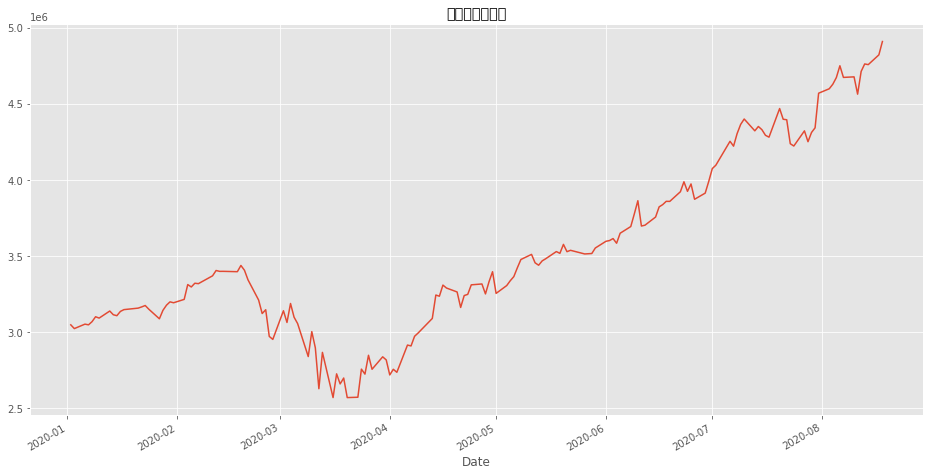

In [22]:
agg_market_cap = market_cap_series.sum(axis=1)
agg_market_cap.plot(title='投资组合指数值');

将起点设为标准值 100。

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26631 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20934 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25237 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36164 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_

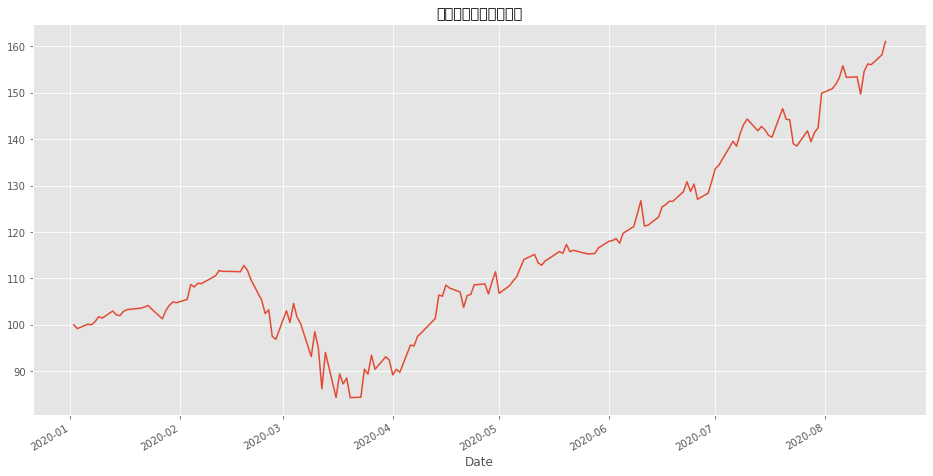

In [23]:
index = agg_market_cap.div(agg_market_cap.iloc[0]).mul(100)
index.plot(title='标准化投资组合指数值');

### <font color='#2b4750' face='微软雅黑'>4.3 评估指数表现</font><a name='4.3'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#4)

评估投资组合的表现可从两个方面进行：

- 收益表现
    - 指数收益  
    - 成分股贡献
- 基准表现
    - 指数对比
    - 滚动收益率对比
    
### <font color='blue' face='微软雅黑'>收益表现</font>

计算指数中每个成分股的变化。

In [24]:
change = market_cap_series.first('D').append(market_cap_series.last('D'))
change.diff().iloc[-1].sort_values()

CME     -9,451.75
CSX      1,323.81
CPRT     1,765.53
AMGN     3,672.82
PEP      5,870.87
PTON    11,351.95
GOLD    20,741.70
TMUS    47,070.43
PYPL    98,345.99
TSLA   271,497.35
AAPL   701,023.78
AMZN   708,498.38
Name: 2020-08-18 00:00:00, dtype: float64

计算指数中每个成分股的权重。

In [26]:
market_cap = components['Market Capitalization']
weights = market_cap.div(market_cap.sum())
weights.sort_values().mul(100)

Stock Symbol
PTON    0.40
CPRT    0.48
GOLD    1.09
CSX     1.16
CME     1.27
AMGN    2.88
TMUS    2.97
PEP     3.89
PYPL    4.65
TSLA    7.16
AMZN   33.79
AAPL   40.25
Name: Market Capitalization, dtype: float64

计算这段期间的指数收益。

In [27]:
index_return = (index.iloc[-1] / index.iloc[0] - 1) * 100
index_return

61.067664005632814

计算这段期间的个股对整个指数收益的贡献，等于个股权重乘以指数收益。

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32929 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20010 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32929 missing from current font.
  font.set_te

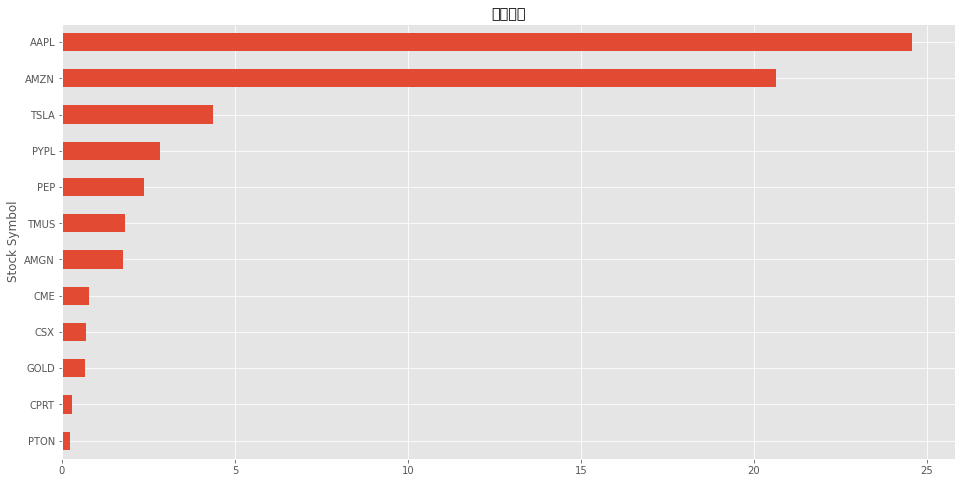

In [29]:
weighted_returns = weights.mul(index_return)
weighted_returns.sort_values().plot(kind='barh', title='个股贡献');

### <font color='blue' face='微软雅黑'>基准表现</font>

用 `to_frame()` 函数将投资组合的指数的 `Series` 格式转成 `DataFrame` 格式。

In [ ]:
index

Date
2020-01-02   100.00
2020-01-03    99.19
2020-01-06   100.15
2020-01-07   100.00
2020-01-08   100.68
              ...  
2020-08-12   154.62
2020-08-13   156.23
2020-08-14   156.08
2020-08-17   158.19
2020-08-18   161.07
Length: 159, dtype: float64

In [30]:
my_portfolio = index.to_frame('My Portfolio')
my_portfolio.head(3).append(my_portfolio.tail(3))

,My Portfolio
Date,
2020-01-02,100.00
2020-01-03,99.19
2020-01-06,100.15
2020-08-14,156.08
2020-08-17,158.19
2020-08-18,161.07


再读取同时期的基准数据，美股基准是标准普尔 500 指数 (S&P 500)。

In [31]:
benchmark = pd.read_csv('S&P 500.csv', parse_dates=['Date'], index_col='Date')
benchmark = benchmark.loc[index.index,:]
benchmark = benchmark.div(benchmark.iloc[0]).mul(100)
benchmark.head(3).append(benchmark.tail(3))

,S&P 500
Date,
2020-01-02,100.00
2020-01-03,99.29
2020-01-06,99.64
2020-08-14,103.53
2020-08-17,103.81
2020-08-18,104.05


将两个 `DataFrame` 按列合并，用 `pd.concat()` 函数并设置 `axis=1`。

In [32]:
benchmarking = pd.concat([my_portfolio, benchmark], axis=1)
benchmarking.head(3).append(benchmarking.tail(3))

,My Portfolio,S&P 500
Date,,
2020-01-02,100.00,100.00
2020-01-03,99.19,99.29
2020-01-06,100.15,99.64
2020-08-14,156.08,103.53
2020-08-17,158.19,103.81
2020-08-18,161.07,104.05


对比组合和基准指数。

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21644 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22522 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20934 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25351 missing from current font.
  font.set_

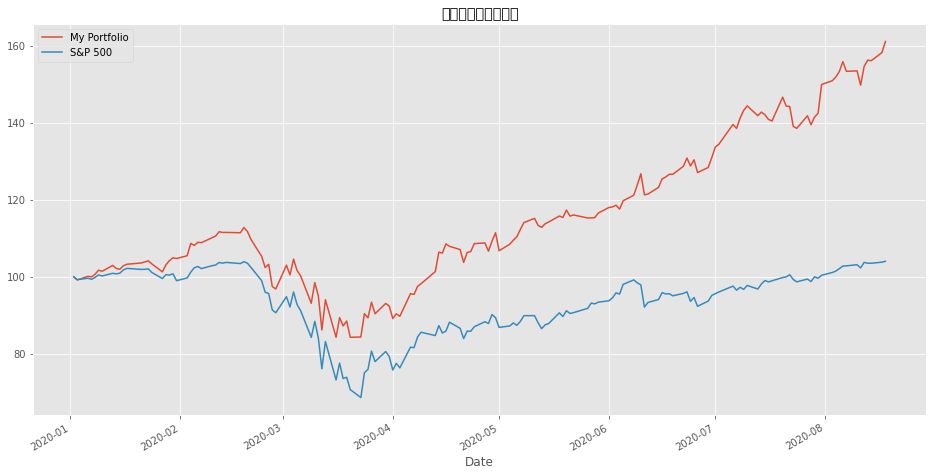

In [33]:
benchmarking.plot(title='组合和基准指数对比');

对比组合和基准滚动收益率。

In [34]:
def multi_period_return(r):
    return (np.prod(r + 1) - 1) * 100

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21644 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22522 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20934 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22825 missing from current font.
  font.set_

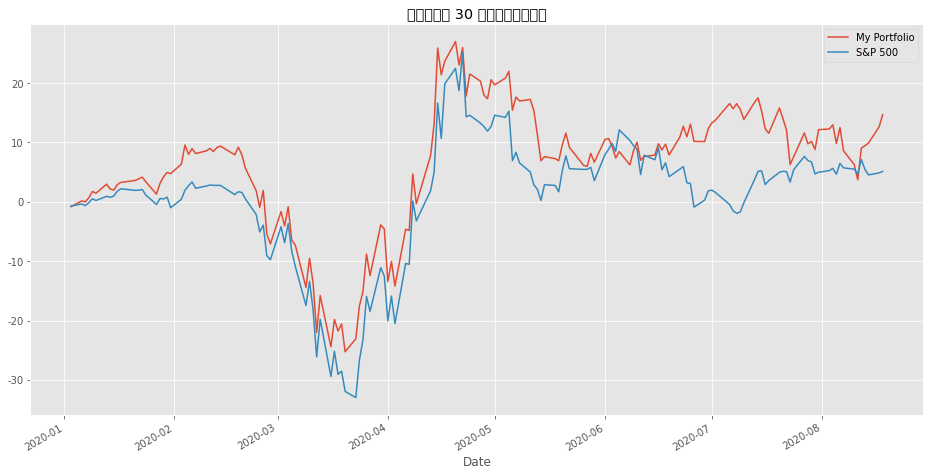

In [ ]:
benchmarking.pct_change().rolling('30D').apply(multi_period_return).plot(title='组合和基准 30 天滚动收益率对比');

### <font color='#2b4750' face='微软雅黑'>4.4 计算相关性系数</font><a name='4.4'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#4)

首先用 `pct_change()` 函数计算日收益率得到一个数据帧，然后在它上面直接用 `corr()` 函数得到一个相关性系数矩阵。

In [36]:
data

,GOLD,TSLA,CPRT,PEP,AMZN,PTON,CME,AMGN,PYPL,TMUS,AAPL,CSX
Date,,,,,,,,,,,,
2020-01-02,18.37,430.26,93.48,133.87,"1,898.01",29.74,200.17,235.23,110.75,78.59,298.29,72.68
2020-01-03,18.45,443.01,92.66,133.68,"1,874.97",30.60,202.84,233.63,108.76,78.17,295.39,72.38
2020-01-06,18.28,451.54,93.49,134.20,"1,902.88",29.75,203.68,235.43,110.17,78.62,297.75,72.00
2020-01-07,18.35,469.06,93.37,132.09,"1,906.86",30.40,203.28,233.21,109.67,78.92,296.35,72.49
2020-01-08,17.71,492.14,94.01,132.77,"1,891.97",29.65,204.38,233.39,111.82,79.42,301.11,72.87
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-12,26.18,"1,554.76",99.98,137.80,"3,162.24",64.36,169.96,240.11,191.32,115.25,452.04,75.03
2020-08-13,27.14,"1,621.00",100.01,138.10,"3,161.02",65.71,169.57,238.86,193.07,115.37,460.04,74.00
2020-08-14,26.99,"1,650.71",100.01,137.56,"3,148.02",64.34,171.44,239.71,191.46,115.49,459.63,74.25


In [40]:
data.corr()

,GOLD,TSLA,CPRT,PEP,AMZN,PTON,CME,AMGN,PYPL,TMUS,AAPL,CSX
GOLD,1.00,0.79,0.01,0.16,0.89,0.82,-0.52,0.69,0.81,0.81,0.66,0.07
TSLA,0.79,1.00,0.34,0.33,0.94,0.91,-0.41,0.70,0.91,0.88,0.90,0.35
CPRT,0.01,0.34,1.00,0.78,0.20,0.28,0.50,0.42,0.40,0.29,0.60,0.94
PEP,0.16,0.33,0.78,1.00,0.21,0.21,0.62,0.52,0.29,0.30,0.47,0.85
AMZN,0.89,0.94,0.20,0.21,1.00,0.96,-0.56,0.75,0.94,0.91,0.86,0.23
PTON,0.82,0.91,0.28,0.21,0.96,1.00,-0.53,0.75,0.97,0.87,0.90,0.27
CME,-0.52,-0.41,0.50,0.62,-0.56,-0.53,1.00,-0.17,-0.43,-0.39,-0.24,0.57
AMGN,0.69,0.70,0.42,0.52,0.75,0.75,-0.17,1.00,0.74,0.60,0.74,0.47
PYPL,0.81,0.91,0.40,0.29,0.94,0.97,-0.43,0.74,1.00,0.92,0.93,0.39
TMUS,0.81,0.88,0.29,0.30,0.91,0.87,-0.39,0.60,0.92,1.00,0.84,0.35


In [38]:
daily_returns = data.pct_change()
daily_returns

,GOLD,TSLA,CPRT,PEP,AMZN,PTON,CME,AMGN,PYPL,TMUS,AAPL,CSX
Date,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.00,0.03,-0.01,-0.00,-0.01,0.03,0.01,-0.01,-0.02,-0.01,-0.01,-0.00
2020-01-06,-0.01,0.02,0.01,0.00,0.01,-0.03,0.00,0.01,0.01,0.01,0.01,-0.01
2020-01-07,0.00,0.04,-0.00,-0.02,0.00,0.02,-0.00,-0.01,-0.00,0.00,-0.00,0.01
2020-01-08,-0.04,0.05,0.01,0.01,-0.01,-0.02,0.01,0.00,0.02,0.01,0.02,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-12,-0.00,0.13,0.00,0.02,0.03,-0.01,0.01,0.03,0.01,0.01,0.03,-0.00
2020-08-13,0.04,0.04,0.00,0.00,-0.00,0.02,-0.00,-0.01,0.01,0.00,0.02,-0.01
2020-08-14,-0.01,0.02,0.00,-0.00,-0.00,-0.02,0.01,0.00,-0.01,0.00,-0.00,0.00


In [39]:
corr = daily_returns.corr()
corr

,GOLD,TSLA,CPRT,PEP,AMZN,PTON,CME,AMGN,PYPL,TMUS,AAPL,CSX
GOLD,1.00,0.32,0.25,0.32,0.26,0.36,0.29,0.26,0.29,0.21,0.25,0.24
TSLA,0.32,1.00,0.43,0.32,0.48,0.15,0.41,0.27,0.45,0.42,0.47,0.43
CPRT,0.25,0.43,1.00,0.69,0.38,0.08,0.57,0.52,0.68,0.55,0.67,0.82
PEP,0.32,0.32,0.69,1.00,0.52,0.22,0.67,0.77,0.69,0.64,0.74,0.75
AMZN,0.26,0.48,0.38,0.52,1.00,0.32,0.39,0.57,0.58,0.52,0.68,0.45
PTON,0.36,0.15,0.08,0.22,0.32,1.00,0.09,0.19,0.24,0.15,0.20,0.03
CME,0.29,0.41,0.57,0.67,0.39,0.09,1.00,0.54,0.60,0.54,0.59,0.73
AMGN,0.26,0.27,0.52,0.77,0.57,0.19,0.54,1.00,0.64,0.51,0.70,0.59
PYPL,0.29,0.45,0.68,0.69,0.58,0.24,0.60,0.64,1.00,0.67,0.79,0.73
TMUS,0.21,0.42,0.55,0.64,0.52,0.15,0.54,0.51,0.67,1.00,0.64,0.62


使用 `seaborn` 中的 `heatmap()` 函数 (热力图) 来可视化相关性系数矩阵，设置 `annot=True` 是把相关性系数的值打印在热力图上，从下图最右边的色彩条可看出，颜色越浅越相关，颜色越深越不相关。

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25910 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20851 missing from current font.
  font.set_

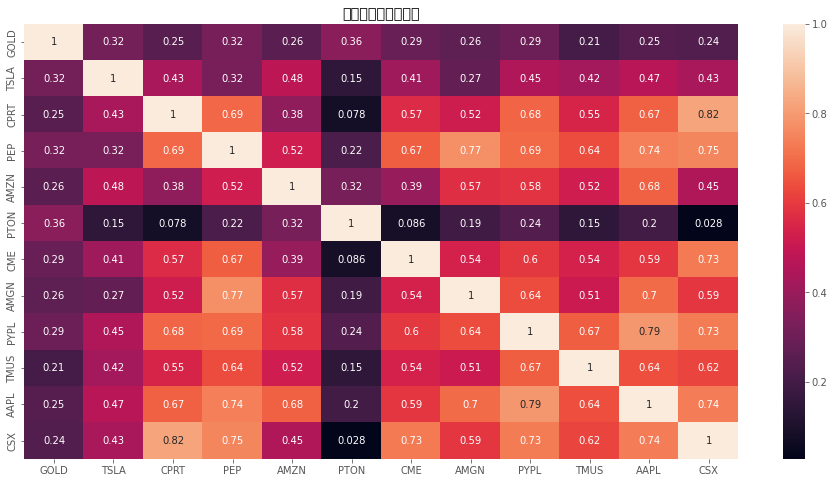

In [41]:
sns.heatmap(corr, annot=True)
plt.title('日收益的相关性系数')
plt.show()

所以分析做完之后，可将结果写到 excel 的**单工作页**或**多工作页**中。

比如将相关性系数矩阵存储到 excel 的 correlations 页中，设置第 1 行和第 1 列作为首行和首列位置。

In [ ]:
corr.to_excel( excel_writer='correlations.xls', 
               sheet_name='correlations', 
               startrow=1,
               startcol=1 )

如果还想存储每个股票的价格和日收益，那么可将结果写到 excel 的**多工作页**中。

In [ ]:
data.index = data.index.date # Keep only date component
data

,GOLD,TSLA,CPRT,PEP,AMZN,PTON,CME,AMGN,PYPL,TMUS,AAPL,CSX
2020-01-02,18.37,430.26,93.48,133.87,"1,898.01",29.74,200.17,235.23,110.75,78.59,298.29,72.68
2020-01-03,18.45,443.01,92.66,133.68,"1,874.97",30.60,202.84,233.63,108.76,78.17,295.39,72.38
2020-01-06,18.28,451.54,93.49,134.20,"1,902.88",29.75,203.68,235.43,110.17,78.62,297.75,72.00
2020-01-07,18.35,469.06,93.37,132.09,"1,906.86",30.40,203.28,233.21,109.67,78.92,296.35,72.49
2020-01-08,17.71,492.14,94.01,132.77,"1,891.97",29.65,204.38,233.39,111.82,79.42,301.11,72.87
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-12,26.18,"1,554.76",99.98,137.80,"3,162.24",64.36,169.96,240.11,191.32,115.25,452.04,75.03
2020-08-13,27.14,"1,621.00",100.01,138.10,"3,161.02",65.71,169.57,238.86,193.07,115.37,460.04,74.00
2020-08-14,26.99,"1,650.71",100.01,137.56,"3,148.02",64.34,171.44,239.71,191.46,115.49,459.63,74.25
2020-08-17,30.13,"1,835.64",101.16,137.92,"3,182.41",65.26,174.61,243.01,196.29,116.87,458.43,74.99


In [ ]:
with pd.ExcelWriter('my_portfolio.xlsx') as writer:
    corr.to_excel(excel_writer=writer, sheet_name='correlations')
    data.to_excel(excel_writer=writer, sheet_name='prices')
    data.pct_change().to_excel(writer, sheet_name='returns')